In [1]:
import torch
import re
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import seaborn as sns
from matplotlib import pyplot as plt 
import matplotlib as mpl
import pandas as pd

sns.set()
mpl.rcParams['font.sans-serif'] = ['Monaco']
mpl.rcParams['axes.unicode_minus']=False 
mpl.rcParams['figure.dpi'] = 100

In [2]:
def data_preprocessing(strings, num_sub="NUM"):
    # 数字代替字符
    res = [re.sub("\d+\.?\d+", num_sub, string.strip()) for string in strings]
    # 将字符变成空格
    res = [re.sub(r'[!\"#$%&\(\)\*\+,-\./:;<=>@\[\]\\\?^_`\{\}~\|]', " ", s) for s in res]
    # 将所有句子连接起来
    res = "".join(res)
    # 多个空格变成一个空格
    res = re.sub(" +", " ", res).lower()
    return res.split(" ")

In [3]:
with open("HarryPotter.txt", "r+", encoding="utf-8") as fp:
    data = fp.readlines()

In [4]:
article = data_preprocessing(data)

In [5]:
uniq_words = set(article)
vocab_size = len(uniq_words)

In [6]:
vocab_size

6066

In [7]:
word2idx = {}
idx2word = {}
my_mapping = []
for idx, word in enumerate(uniq_words):
    word2idx[word] = idx
    idx2word[idx] = word
    my_mapping.append(word)
my_mapping = np.array(my_mapping)

In [8]:
my_mapping

array(['snap', 'tibbles', 'transfixed', ..., "guardin'", "minutes'",
       'stamp'], dtype='<U18')

In [9]:
my_mapping[[0, 1, 2, -3, -2, -1]]

array(['snap', 'tibbles', 'transfixed', "guardin'", "minutes'", 'stamp'],
      dtype='<U18')

In [10]:
num_article = []
for word in article:
    num_article.append(word2idx[word])
num_article = np.array(num_article)

In [11]:
num_article

array([1517, 5193, 2983, ..., 5792, 3424, 1747])

In [82]:
def dataset_extractor(article, left_window=8, right_window=8, num_words_selected=8):
    '''
    article : 文章对应的数字列表
    num_words_selected : 每个中心词需要抽取多少个对应的上下文单词
    left_window : 中心词左边带抽取单词的范围
    right_window : 中心词右边边带抽取单词的范围
    '''
    length = len(article)
    dataset = []
    labels = []
    for idx, word_num in enumerate(article[1:-1]):
        idx = idx + 1
        if idx <= left_window:
            temp = np.array([idx - 1, idx + 1])
            num_idx = list(np.arange(0, idx - 1)) + list(temp) + list(np.arange(idx + 2, idx + 1 + right_window))
        elif length - idx -1 <= right_window:
            temp = np.array([idx - 1, idx + 1])
            num_idx = list(np.arange(idx - left_window, idx - 1)) + list(temp) + list(np.arange(idx + 2, length))
        else:
            temp = np.array([idx - 1, idx + 1])
            num_idx = list(np.arange(idx - left_window, idx - 1)) + list(temp) + list(np.arange(idx + 2, idx + 1 + right_window))
        nums = article[num_idx]
        if len(nums) > num_words_selected:
            nums = np.random.choice(nums, size=num_words_selected, replace=False)
        labels += [article[idx].tolist()]
        dataset += nums.tolist()
    return labels, dataset

In [83]:
labels, dataset = dataset_extractor(article=num_article, left_window=8, right_window=8,
                                               num_words_selected=8)

In [84]:
dataset = torch.from_numpy(np.array(dataset))
labels = torch.from_numpy(np.array(labels))

In [85]:
dataset = dataset.reshape(-1, 8)

In [86]:
dataset

tensor([[5698, 2478, 2983,  ..., 3424, 1517, 2912],
        [1517, 1090, 5698,  ..., 5191, 3024, 2478],
        [3001, 2912, 1090,  ..., 2983, 5191, 2983],
        ...,
        [5792, 1747, 3424,  ..., 4558, 1035,  483],
        [4200, 2695, 3424,  ..., 1035, 3593, 4558],
        [1747, 4200, 3593,  ...,  827, 4558,  483]])

In [87]:
len(dataset)

77889

In [88]:
len(labels)

77889

In [90]:
class MyDataset(Dataset):
    
    def __init__(self, data, label):
        super(MyDataset, self).__init__()
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [91]:
dataset = MyDataset(dataset, labels)

In [93]:
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True, num_workers=4)

In [94]:
loss_ans = pd.DataFrame()

In [95]:
next(iter(data_loader))

[tensor([[2571, 2052, 1024, 5312, 2141, 3222,  804, 3341],
         [ 666, 5103, 4198, 5838, 4200, 2140, 2535, 4257],
         [5256, 3163, 2994, 1559, 1559, 2983, 1242, 5740],
         [ 177, 1135, 4685, 2442, 2442, 3424, 1529, 5629],
         [3119, 1559, 3280,  414, 2596, 5081, 3424, 4744],
         [3779, 1773, 5872, 4163, 2354, 1891, 5907, 1517],
         [1242, 4293, 2917, 1865, 1985,  718, 3136, 1242],
         [3593, 2938, 3261, 1178, 5639, 3424, 1469, 1559],
         [2486,  463, 2140, 2714, 5610, 3306, 1666, 1135],
         [3593, 3593,  353,  698, 5778, 5922, 2039, 2100],
         [4012, 2912, 4283, 5897, 3424, 2758, 3926, 2601],
         [5750, 4971, 5871, 4765, 2983,  483, 2776, 2121],
         [1909,  290, 4661, 2286, 3981, 2140, 4999, 1909],
         [3941, 2983, 4293, 3946, 3424, 4710, 1838, 1517],
         [5273, 1024, 5978, 5689, 1019, 5161, 2983, 5733],
         [2140,  240, 5138, 3593, 1922, 1570, 1730, 5009]]),
 tensor([2710, 1243, 1909, 1454, 5689, 1838, 2567, 592

In [111]:
class CBOW(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, squence_length):
        
        super(CBOW, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.squence_length = squence_length
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size * squence_length, vocab_size)
        self.logosoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.embedding(x)
        out = out.view(-1, self.squence_length * self.embedding_size)
        out = self.linear(out)
        return self.logosoftmax(out)

In [112]:
model = CBOW(256, vocab_size, 8)
lr = 8e-4
epoch = 40
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
criteiron = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
losses = []

In [158]:
model = model.to(device)
for e in range(epoch):
    temp_losses = []
    for idx, data in enumerate(data_loader):
        data, label = data
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = criteiron(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp_losses.append(loss.item())
        print(f"Epoch [{e + 1}/{epoch}] Step [{idx + 1}/{len(data_loader)}] loss = {loss.item()}")
    losses.append(np.mean(temp_losses))
    sns.lineplot(x = np.arange(len(temp_losses)), y = temp_losses)
    plt.show()
    plt.pause(0.005)

Text(0, 0.5, 'loss')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


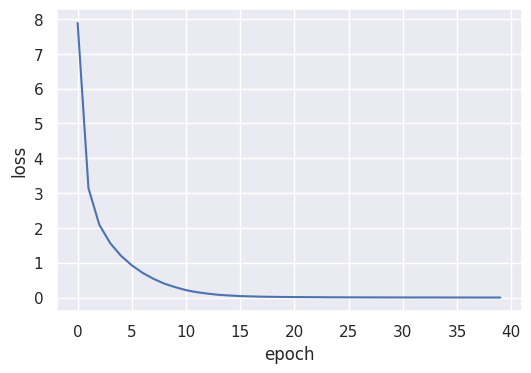

In [114]:
ax = sns.lineplot(x = range(len(losses)),  y=losses)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

In [115]:
word2idx["like"]

1281

In [116]:
word2idx["love"]

513

In [117]:
torch.tensor([word2idx["like"]])

tensor([1281])

In [118]:
model = model.cpu()

In [121]:
like = model.embedding(torch.tensor([word2idx["king"]]))[0]

In [122]:
love = model.embedding(torch.tensor([word2idx["queen"]]))[0]

In [123]:
weights = model.embedding.weight.data

In [124]:
def cos(x, y, weights):
    x = weights[word2idx[x]]
    y = weights[word2idx[y]]
    ab = torch.dot(x, y)
    a = torch.sqrt(torch.sum(x ** 2))
    b = torch.sqrt(torch.sum(y ** 2))
    return ab / (a * b)

In [125]:
cos('love', 'like', weights)

tensor(0.0294)

In [126]:
cos('love', 'hate', weights)

tensor(0.0107)

In [127]:
cos('likes', 'like', weights)

tensor(-0.0239)

In [128]:
cos('king', 'queen', weights)

tensor(-0.0279)

In [129]:
cos('man', 'woman', weights)

tensor(0.1874)

In [130]:
cos('man', 'king', weights)

tensor(0.0606)

In [131]:
cos('woman', 'queen', weights)

tensor(0.0250)

In [132]:
cos('better', 'worse', weights)

tensor(-0.0728)

In [133]:
cos('good', 'bad', weights)

tensor(0.0584)

In [134]:
cos('old', 'new', weights)

tensor(-0.0218)

In [135]:
cos('ron', 'harry', weights)

tensor(-0.0016)

In [136]:
cos('dumbledore', 'voldemort', weights)

tensor(0.0703)

In [137]:
torch.sqrt(torch.sum(like ** 2))

tensor(18.5224, grad_fn=<SqrtBackward>)

In [145]:
def similar_by_word(word, weights, word2idx, idx2word, my_mapping, topk=1):
    vc = weights[word2idx[word]]
    coses = []
    for i, v in enumerate(weights):
        if i == word2idx[word]:
            continue
        coses.append(cos(word, idx2word[i], weights))
    coses = torch.Tensor(coses)
    return list(zip(torch.topk(coses, topk)[0], my_mapping[torch.topk(coses, topk)[1]]))

In [146]:
similar_by_word("ron", weights, word2idx, idx2word, my_mapping, topk=10)

[(tensor(0.2178), 'copy'),
 (tensor(0.2147), 'wardrobes'),
 (tensor(0.2000), 'parted'),
 (tensor(0.1923), 'shooting'),
 (tensor(0.1847), 'bottom'),
 (tensor(0.1845), 'poor'),
 (tensor(0.1838), 'hills'),
 (tensor(0.1827), 'friar'),
 (tensor(0.1816), 'raised'),
 (tensor(0.1808), 'steering')]

In [147]:
def plot_with_labels(low_dim_embs, labels, xlims=None, ylims=None):
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    if xlims:
        plt.xlim(*xlims)
    if ylims:
        plt.ylim(*ylims)
    plt.show()

In [148]:
def visual(words, weights, word2idx, xlims=None, ylims=None):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    idxs = [word2idx[word.lower()] for word in words]
    low_dim_embs = tsne.fit_transform(weights[idxs])
    labels = [idx2word[i] for i in idxs ]
    plot_with_labels(low_dim_embs, labels, xlims, ylims)

In [149]:
from sklearn.manifold import TSNE

In [150]:
weights.shape

torch.Size([6066, 256])

In [151]:
weights[[word2idx["ron"], word2idx["harry"], word2idx["dumbledore"], word2idx["voldemort"]]].shape

torch.Size([4, 256])

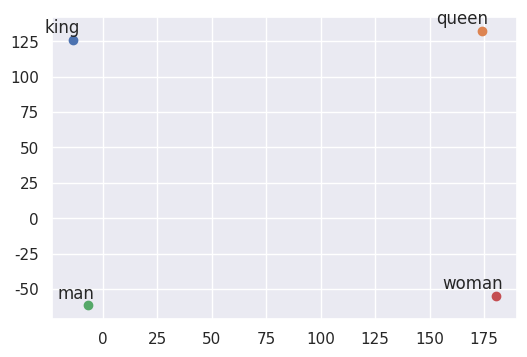

In [152]:
visual(["king", "queen", "man", "woman"], weights, word2idx)

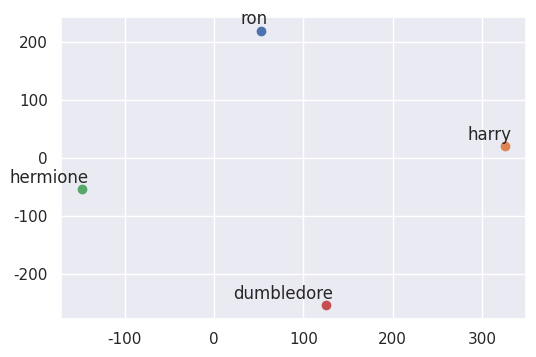

In [153]:
visual(["ron","harry","Hermione", "dumbledore"], weights, word2idx)

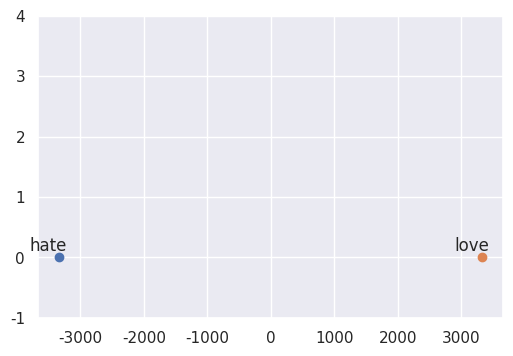

In [154]:
visual(["hate", "love"], weights, word2idx, ylims=[-1, 4])

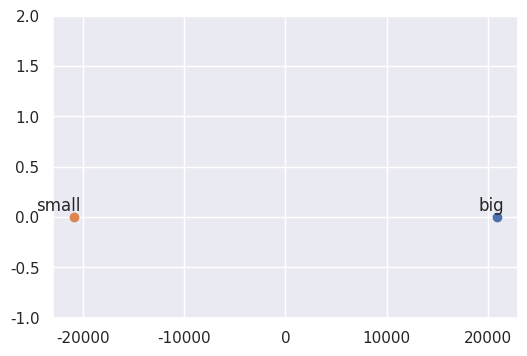

In [155]:
visual(["big", "small"], weights, word2idx, ylims=[-1, 2])

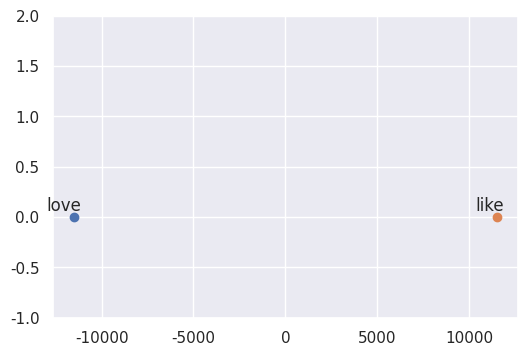

In [156]:
visual(["love", "like"], weights, word2idx, ylims=[-1, 2])

In [162]:
model

CBOW(
  (embedding): Embedding(6066, 256)
  (linear): Linear(in_features=2048, out_features=6066, bias=True)
  (logosoftmax): LogSoftmax()
)